# Fraud-Analytics for Mastercard Internship
## Lorenzo D'Amcio | April 2025

## 1 - Import Libraries


In [4]:
# 1.0 – Import Libraries
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_curve, confusion_matrix, classification_report,
    roc_auc_score, average_precision_score
)
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier

sns.set_theme(style="whitegrid")

# 2 - Load dataset and feature engineering

In [6]:
# WARNING: Replace this path with the correct one on your system
df = pd.read_csv("/home/lorenzods/progetto_mastercard/dataset/creditcard_enhanced_UAE_FINAL.csv")
# Create the cost_if_fraud column (estimated fraud cost)
df["cost_if_fraud"] = 4.19 * df["Amount"]
# Create a binary flag for transactions >= 50k AED
df["flag_over_50k"] = (df["Amount"] >= 50000).astype(int)
print(df.head(3))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...  transaction_type  Time_days      geo_area  \
0  0.098698  0.363787  ...               B2C   0.000000  Dubai_Marina   
1  0.085102 -0.255425  ...               B2C   0.000000       Sharjah   
2  0.247676 -1.514654  ...               B2C   0.000012        Al_Ain   

   customer_id  customer_type  age  is_3DS  is_tokenized  cost_if_fraud  \
0       123304          EXPAT   37       0             1       626.9078   
1       479353          EXPAT   37       1             1        11.2711   
2       512369          EXPAT   30       1             0      1586.5854   

   flag_over_50k  
0              0  
1              0  
2              0  

[3 r

# 3 - Exploratiory Data Analysis (EDA)

In [7]:
# -- 3.1 Total transactions and fraud rate --
fraud_count = df['Class'].sum()
total_count = len(df)
fraud_rate = fraud_count / total_count * 100
print(f"\nTotal transactions: {total_count}")
print(f"Number of frauds: {fraud_count} ({fraud_rate:.4f}% of total)")


Total transactions: 284807
Number of frauds: 492 (0.1727% of total)


In [10]:
# -- 3.2 Fraud rate by selected features --
group_features = ['transaction_type', 'customer_type', 'is_3DS','is_tokenized', 'geo_area']
fraud_rates = {}
for feature in group_features:
    fraud_rates[feature] = (df.groupby(feature)['Class'].mean() * 100).round(3)
for feature, rates in fraud_rates.items():
    print(f"\nFraud rate (%) for: {feature}")
    display(rates)



Fraud rate (%) for: transaction_type


transaction_type
B2B    0.184
B2C    0.168
Name: Class, dtype: float64


Fraud rate (%) for: customer_type


customer_type
EXPAT    0.173
LOCAL    0.174
Name: Class, dtype: float64


Fraud rate (%) for: is_3DS


is_3DS
0    0.184
1    0.162
Name: Class, dtype: float64


Fraud rate (%) for: is_tokenized


is_tokenized
0    0.172
1    0.174
Name: Class, dtype: float64


Fraud rate (%) for: geo_area


geo_area
Abu_Dhabi         0.176
Al_Ain            0.133
Dubai_Marina      0.163
Fujairah          0.159
Ras_Al_Khaimah    0.194
Sharjah           0.194
Name: Class, dtype: float64

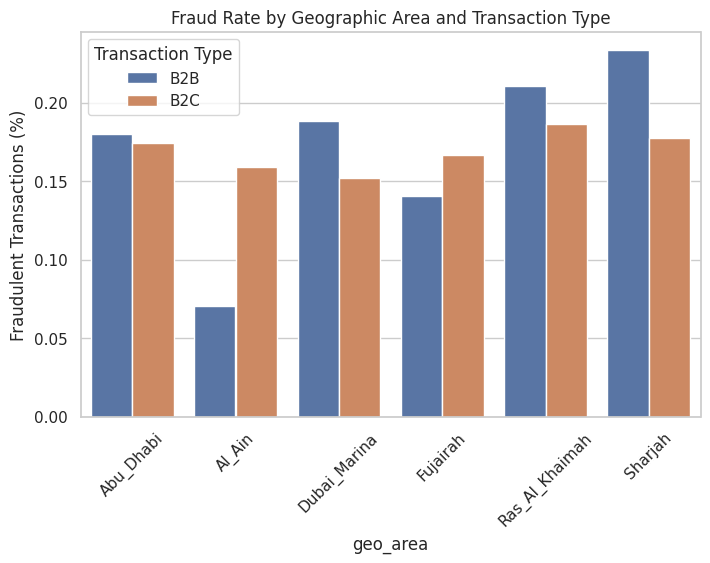

In [11]:
# -- 3.3 Barplot: fraud rate by (geo_area, transaction_type) --
plt.figure(figsize=(8, 5))
geo_type_rates = df.groupby(['geo_area', 'transaction_type'])['Class'].mean().reset_index()
geo_type_rates['Class'] = geo_type_rates['Class'] * 100.0
sns.barplot(x='geo_area', y='Class', hue='transaction_type', data=geo_type_rates)
plt.title("Fraud Rate by Geographic Area and Transaction Type")
plt.ylabel("Fraudulent Transactions (%)")
plt.xticks(rotation=45)
plt.legend(title='Transaction Type')
plt.show()

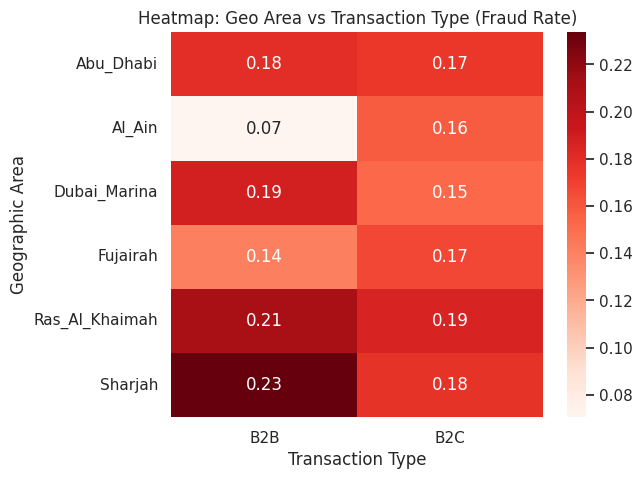

In [12]:
# -- 3.4 Heatmap (geo_area vs transaction_type) --
pivot_rates = geo_type_rates.pivot(index='geo_area', columns='transaction_type', values='Class')
plt.figure(figsize=(6, 5))
sns.heatmap(pivot_rates, annot=True, fmt=".2f", cmap="Reds")
plt.title("Heatmap: Geo Area vs Transaction Type (Fraud Rate)")
plt.ylabel("Geographic Area")
plt.xlabel("Transaction Type")
plt.show()

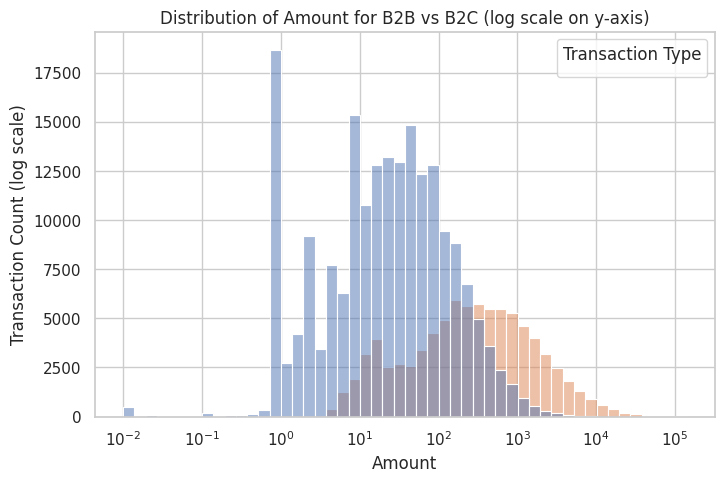

In [13]:
# -- 3.5 Distribution of Amount (B2B vs B2C) --
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Amount', hue='transaction_type', bins=50, log_scale=True)
plt.title("Distribution of Amount for B2B vs B2C (log scale on y-axis)")
plt.xlabel("Amount")
plt.ylabel("Transaction Count (log scale)")
plt.legend(title='Transaction Type')
plt.show()

In [15]:
# -- 3.6 Fraud rate summary table --
summary_rows = []
for feature, rates in fraud_rates.items():
    for category, rate in rates.items():
        summary_rows.append([feature, str(category), f"{rate:.3f}%"])
        summary_df = pd.DataFrame(summary_rows, columns=["Feature", "Category", "Fraud Rate (%)"])
print("\nSummary Table – Fraud rate by category:")
display(summary_df)


Summary Table – Fraud rate by category:


,Feature,Category,Fraud Rate (%)
0,transaction_type,B2B,0.184%
1,transaction_type,B2C,0.168%
2,customer_type,EXPAT,0.173%
3,customer_type,LOCAL,0.174%
4,is_3DS,0,0.184%
5,is_3DS,1,0.162%
6,is_tokenized,0,0.172%
7,is_tokenized,1,0.174%
8,geo_area,Abu_Dhabi,0.176%
9,geo_area,Al_Ain,0.133%



Number of transactions below 50000 AED: 284755
Number of transactions >= 50000 AED: 52
Percentage of high-value (￿50k) transactions: 0.02%

=== Stats: SMALL AMOUNTS (< 50K) ===


count    284755.000000
mean        379.534752
std        1550.935692
min           0.000000
25%           9.990000
50%          41.000000
75%         181.448153
max       49229.938292
Name: Amount, dtype: float64

Fraud Rate in df_small: 0.1728%

=== Stats: LARGE AMOUNTS (￿ 50K) ===


count        52.000000
mean      77340.722369
std       22541.808687
min       51327.732936
25%       60565.299574
50%       73123.936508
75%       88255.787651
max      140355.571485
Name: Amount, dtype: float64

Fraud Rate in df_large: 0.0000%


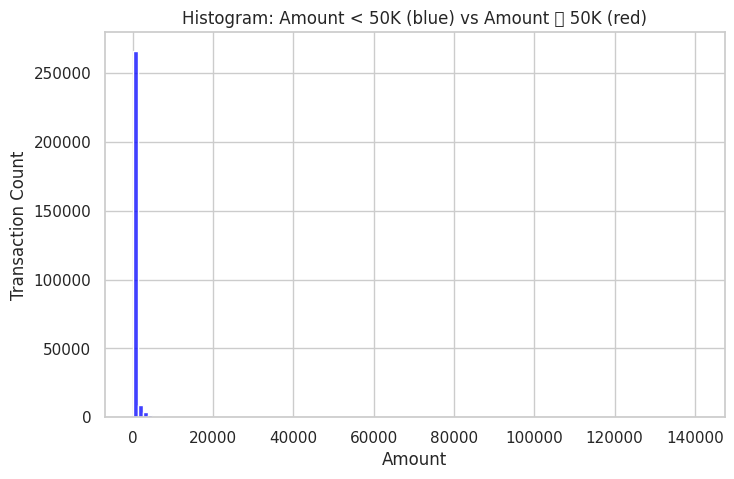

In [16]:
# -- 3.7 Segmentation based on 50k threshold --
threshold_50k = 50000
df_small = df[df['Amount'] < threshold_50k].copy()
df_large = df[df['Amount'] >= threshold_50k].copy()
print(f"\nNumber of transactions below {threshold_50k} AED: {len(df_small)}")
print(f"Number of transactions >= {threshold_50k} AED: {len(df_large)}")
print(f"Percentage of high-value (￿50k) transactions: {len(df_large) / len(df) * 100:.2f}%")
print("\n=== Stats: SMALL AMOUNTS (< 50K) ===")
display(df_small['Amount'].describe())
print(f"Fraud Rate in df_small: {df_small['Class'].mean()*100:.4f}%")
print("\n=== Stats: LARGE AMOUNTS (￿ 50K) ===")
display(df_large['Amount'].describe())
print(f"Fraud Rate in df_large: {df_large['Class'].mean()*100:.4f}%")
# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(df_small['Amount'], color='blue', kde=False, bins=40)
sns.histplot(df_large['Amount'], color='red', kde=False, bins=40)
plt.title("Histogram: Amount < 50K (blue) vs Amount ￿ 50K (red)")
plt.xlabel("Amount")
plt.ylabel("Transaction Count")
plt.show()

# 4 Real-time Modelling (XGBOOST)

In [17]:
df_main = df.copy() # Define working copy
# Define target
target_column = "Class"
y_full = df_main[target_column]
drop_cols = ["Class", "cost_if_fraud", "flag_over_50k", "customer_id", "Time"]
X_full = df_main.drop(columns=[col for col in drop_cols if col in df_main.columns])
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.25, stratify=y_full, random_state=42)
idx_train = X_train.index
idx_test = X_test.index
# Encoding
if "transaction_type" in X_train.columns:
    X_train["transaction_type"] = X_train["transaction_type"].map({"B2C": 0,"B2B": 1})
    X_test["transaction_type"] = X_test["transaction_type"].map({"B2C": 0,"B2B": 1})
if "customer_type" in X_train.columns:
    X_train["customer_type"] = X_train["customer_type"].map({"EXPAT": 0, "LOCAL": 1})
    X_test["customer_type"] = X_test["customer_type"].map({"EXPAT": 0, "LOCAL": 1})
if "geo_area" in X_train.columns:
    X_train = pd.get_dummies(X_train, columns=["geo_area"], prefix="geo")
    X_test = pd.get_dummies(X_test, columns=["geo_area"], prefix="geo")
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
    X_test = X_test[X_train.columns]
# Scaling
num_cols = [c for c in X_train.columns if c not in ["transaction_type", "customer_type", "is_3DS", "is_tokenized"] and not c.startswith("geo_")]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train XGBoost
model = XGBClassifier(learning_rate=0.1,max_depth=3,scale_pos_weight=50,subsample=1.0,eval_metric="logloss",random_state=42)
model.fit(X_train_scaled, y_train)
# Predict
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# 5 Cost-based Threshold Tuning 


Best threshold: 0.465
Estimated minimum cost: 89,288.28 AED

Confusion Matrix with best threshold:


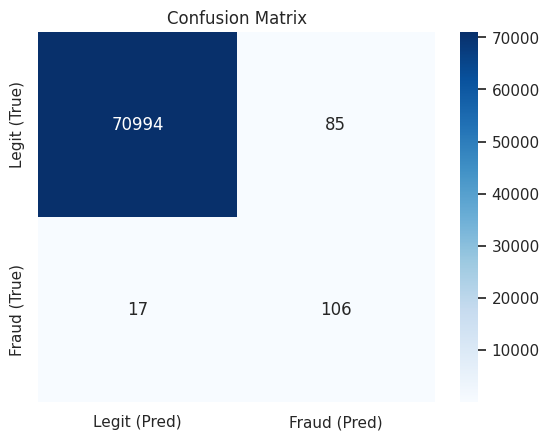

In [19]:
costs_test = df_main.loc[idx_test, "cost_if_fraud"].values
thresholds = np.linspace(0.01, 0.99, 100)
best_thr = 0.5
min_cost = float("inf")
for thr in thresholds:
    y_pred_tmp = (y_prob >= thr).astype(int)
    fp_mask = (y_pred_tmp == 1) & (y_test.values == 0)
    fn_mask = (y_pred_tmp == 0) & (y_test.values == 1)
    cost_fp = fp_mask.sum() * 50 # fixed false positive cost
    cost_fn = costs_test[fn_mask].sum()
    total_cost = cost_fp + cost_fn
    if total_cost < min_cost:
        min_cost = total_cost
        best_thr = thr
print(f"\nBest threshold: {best_thr:.3f}")
print(f"Estimated minimum cost: {min_cost:,.2f} AED")
# Confusion Matrix
y_pred_best = (y_prob >= best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix with best threshold:")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
xticklabels=["Legit (Pred)", "Fraud (Pred)"],
yticklabels=["Legit (True)", "Fraud (True)"])
plt.title("Confusion Matrix")
plt.show()

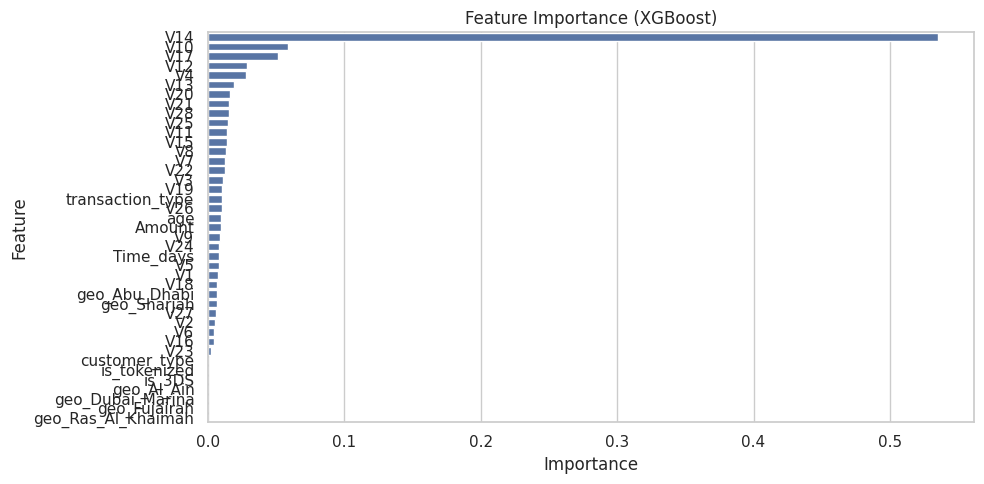

In [22]:
# 5.1 Feature Importance
importance = model.feature_importances_
features = X_train.columns
imp_df = pd.DataFrame({"Feature": features, "Importance": importance}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(data=imp_df, x="Importance", y="Feature")
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

# 6 - Business Impact Simulation 

In [25]:
def simulate_business_impact(df_main,model,best_thr,scaler,train_columns,annual_volume=12_000_000,cost_fp_unit=50):
    df_seg_main = df_main[df_main["Amount"] < 50000].copy()
    y_seg_main = df_seg_main["Class"]
    X_seg_main = df_seg_main.drop( columns=["Class", "customer_id", "Time", "cost_if_fraud","flag_over_50k"],errors="ignore") 
    X_seg_main = pd.get_dummies(X_seg_main)
    X_seg_main = X_seg_main.reindex(columns=train_columns, fill_value=0)
    X_seg_main_scaled = scaler.transform(X_seg_main)
    cost_main = df_seg_main["cost_if_fraud"].values
    y_scores = model.predict_proba(X_seg_main_scaled)[:, 1]
    y_pred = (y_scores >= best_thr).astype(int)
    fp_mask = (y_pred == 1) & (y_seg_main.values == 0)
    fn_mask = (y_pred == 0) & (y_seg_main.values == 1)
    cost_fp = fp_mask.sum() * cost_fp_unit
    cost_fn = cost_main[fn_mask].sum()
    df_high_value = df_main[df_main["Amount"] >= 50000]
    cost_manual_check = len(df_high_value) * cost_fp_unit
    scaling_factor = annual_volume / len(df_seg_main)
    annual_cost_fp = cost_fp * scaling_factor
    annual_cost_fn = cost_fn * scaling_factor
    annual_cost_manual = cost_manual_check * scaling_factor
    total_cost = annual_cost_fp + annual_cost_fn + annual_cost_manual
    return {"Annual transaction volume": annual_volume, "Main segment (<50K) transactions": len(df_seg_main),"High-value (50K) transactions": len(df_high_value),
            "False positive rate (<50K)": fp_mask.mean(),"False negative rate (<50K)": fn_mask.mean(),"Estimated false negatives": fn_mask.sum(),
            "Annual FP cost": annual_cost_fp,"Annual FN cost": annual_cost_fn,"Manual review cost (<50K)": annual_cost_manual,
            "TOTAL estimated annual cost": total_cost 
}

In [29]:
# Run simulation
results_sim = simulate_business_impact(df_main=df_main,model=model,best_thr=best_thr,scaler=scaler,train_columns=X_train.columns)
print("\n--- Business Impact Simulation ---")
for k, v in results_sim.items():
    if isinstance(v, float):
        print(f"{k}: {v:,.2f}")
    else:
        print(f"{k}: {v}" ) 


--- Business Impact Simulation ---
Annual transaction volume: 12000000
Main segment (<50K) transactions: 284755
High-value (50K) transactions: 52
False positive rate (<50K): 0.00
False negative rate (<50K): 0.00
Estimated false negatives: 38
Annual FP cost: 589,980.86
Annual FN cost: 6,590,779.56
Manual review cost (<50K): 109,567.87
TOTAL estimated annual cost: 7,290,328.29


# 4 – Unsupervised Anomaly Detection (Isolation Forest + Ensemble + LOF)

In [30]:
# 4.0– Recalculate y_scores on df_main
X_main = df_main.drop( columns=["Class", "customer_id", "Time", "cost_if_fraud", "flag_over_50k"],errors="ignore")
# One-hot encode and align columns (using the same columns as in X_train)
X_main = pd.get_dummies(X_main)
X_main = X_main.reindex(columns=X_train.columns, fill_value=0)
X_main_scaled = scaler.transform(X_main)
# Get predicted fraud probabilities for ALL transactions in df_main
y_scores = model.predict_proba(X_main_scaled)[:, 1]

In [31]:
#  4.1 – Filter transactions that XGBoost predicted as LEGIT
mask_pred_legit = (y_scores < best_thr)
df_pred_legit = df_main[mask_pred_legit].copy()
# Prepare features for the legit subset
X_legit = df_pred_legit.drop(columns=["Class", "customer_id", "Time", "cost_if_fraud", "flag_over_50k"],errors="ignore")
X_legit = pd.get_dummies(X_legit)
X_legit = X_legit.reindex(columns=X_train.columns, fill_value=0)
X_legit_scaled = scaler.transform(X_legit)

In [33]:
# 4.2 – Fit Isolation Forest and LOF on “legit” predictions
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(X_legit_scaled)
# decision_function returns +scores (higher = more normal).
# We take negative to have "more positive" = more outlier.
anomaly_scores_iso = iso_forest.decision_function(X_legit_scaled)
df_pred_legit["anomaly_score_iforest"] = -anomaly_scores_iso
# Threshold for top ~1.5% of anomalies within these “legit” transactions
threshold_iso = np.percentile(df_pred_legit["anomaly_score_iforest"], 98.5)
df_pred_legit["flag_iforest"] = df_pred_legit["anomaly_score_iforest"] >= threshold_iso

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof_flags = lof.fit_predict(X_legit_scaled) # returns -1 for outliers
df_pred_legit["flag_lof"] = (lof_flags == -1)

In [36]:
# 4.3 – Ensemble Decision: XGBoost OR (IF OR LOF)
# 1) “flag_xgb” = True if XGBoost thinks it's fraud (>= best_thr)
df_main["flag_xgb"] = (y_scores >= best_thr)
# 2) Combine IF and LOF flags into the main df for “legit < 50K” subset
ensemble_flags = pd.Series(False, index=df_main.index)
# We only apply the unsupervised flags to transactions < 50K that XGBoost labeled as legit. Those are in df_pred_legit.
ensemble_flags.loc[df_main["Amount"] < 50000] = (df_pred_legit["flag_iforest"] | df_pred_legit["flag_lof"])
# Final ensemble: flagged if XGBoost says "fraud" OR if unsupervised says "fraud"
df_main["flag_ensemble"] = df_main["flag_xgb"] | ensemble_flags

In [38]:
# 4.4 – Evaluate overall performance
y_true = df_main["Class"]
y_pred_ensemble = df_main["flag_ensemble"]
cm = confusion_matrix(y_true, y_pred_ensemble)
print("\nEnsemble Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred_ensemble, digits=4))
# Analyze any frauds that slip through the entire ensemble
df_main["was_fraud"] = (df_main["Class"] == 1)
df_main["caught_by_ensemble"] = df_main["flag_ensemble"]
remaining_frauds = df_main[(df_main["was_fraud"] == True) & (df_main["caught_by_ensemble"] == False)]
print(f"\n Remaining undetected frauds after ensemble:{len(remaining_frauds)}")
print(f" Potential cost of missed frauds (ensemble):{remaining_frauds['cost_if_fraud'].sum():,.2f} AED")
# Optional: see how many frauds were successfully caught
recovered = df_main[df_main["flag_ensemble"] & (df_main["Class"] == 1)]
print(f"\n Total frauds detected by ensemble: {len(recovered)}")
print(f" Value of captured frauds: {recovered['cost_if_fraud'].sum():,.2f} AED")


Ensemble Confusion Matrix:
 [[277109   7206]
 [    34    458]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.9747    0.9871    284315
           1     0.0598    0.9309    0.1123       492

    accuracy                         0.9746    284807
   macro avg     0.5298    0.9528    0.5497    284807
weighted avg     0.9983    0.9746    0.9856    284807


 Remaining undetected frauds after ensemble:34
 Potential cost of missed frauds (ensemble):138,822.65 AED

 Total frauds detected by ensemble: 458
 Value of captured frauds: 1,198,213.53 AED
